<a href="https://colab.research.google.com/github/nooraovo/nooraovo.github.io/blob/main/Multi_neuron_exp1_rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy

In [4]:
class TwoLayerNN(nn.Module):
  def __init__(self, m, d): # fix the second layer to be all 1
    super().__init__()
    self.fc1 = nn.Linear(d, m, bias=False)
    self.fc2 = nn.Linear(m, 1, bias=False)

  def activation(self, x): # cubic relu activation
    return (x.clamp(min=0))

  def forward(self, x):
    _output = self.activation(self.fc1(x))
    output = self.fc2(_output)
    return output

In [36]:
n = 30
D_in = 2
D_out = 1
m = 30
l0_threshold_grad_matrix = 0.0001

def get_data(n, D_in):
  x=torch.randn(n,D_in)
  torch.nn.init.normal_(x, 0, 1) # initialize x

  u=torch.rand(D_in,D_out)
  u=u/u.norm() # ||u||=1
  y=x.mm(u)
  y=y.clamp(min=0)

  return x, y

In [23]:
x, y = get_data(n, D_in)
model =  TwoLayerNN(m, D_in)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, weight_decay=0)
criteria = nn.MSELoss()

In [24]:
def weights_init(m):
  for p in m.parameters():
    nn.init.xavier_uniform_(p, gain=.1)

# def train(epochs, lr):
#   model =  TwoLayerNN(m, D_in)
#   model.apply(weights_init)
#   optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=0)

#   model.train()
#   res = []
#   for epoch in range(epochs):
#     output = model(x)
#     loss = criteria(output, y)

#     optimizer.zero_grad()
#     loss.backward()

#     optimizer.step()

#     tmp = []
#     flag = 0
#     for p in model.parameters():
#       print(np.linalg.matrix_rank(p.data.numpy()))
#       tmp += np.linalg.matrix_rank(p.data.numpy())
#       break;
#       # tmp += [(p.clone().detach()**2).sum(dim=-1).numpy()]

#     res += [tmp]
#     if epoch % 100 == 0:
#       print (epoch, loss.item())

#   return np.array(res)
def train(epochs, lr):
  train_loss, nets_avg = [], []
  model = TwoLayerNN(m, D_in)
  model.apply(weights_init)
  net, net_avg = copy.deepcopy(model), copy.deepcopy(model)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0, weight_decay=0)
  net.train()

  for epoch in range(epochs):
    output = net(x)
    loss = criteria(output, y)
    if epoch % 100 == 0:
      print (epoch, loss.item())
    train_loss += [loss.item()]
    nets_avg.append(copy.deepcopy(net))

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  return train_loss, nets_avg

In [25]:
def compute_grad_matrix(net, X):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.0)
    grad_matrix_list = []
    for i in range(X.shape[0]):
        h = net(X[[i]])
        optimizer.zero_grad()
        h.backward()

        grad_total_list = []
        for param in net.parameters():
            grad_total_list.append(param.grad.flatten().data.numpy())
        grad_total = np.concatenate(grad_total_list)
        grad_matrix_list.append(grad_total)

    grad_matrix = np.vstack(grad_matrix_list)
    return grad_matrix

def compute_grad_matrix_ranks(nets, X, l0_threshold_grad_matrix=0.0001):
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    X_eval = X[:n_params]
    grad_matrix_ranks = []
    for net in nets:
        svals = np.linalg.svd(compute_grad_matrix(net, X_eval))[1]
        rank = (svals / svals[0] > l0_threshold_grad_matrix).sum()
        grad_matrix_ranks.append(rank)
    return grad_matrix_ranks

In [31]:
lr_small = 0.005
loss_small, net_small = train(15000, lr=lr_small)

0 0.6252213716506958
100 0.6122740507125854
200 0.5840936899185181
300 0.502241849899292
400 0.3209799826145172
500 0.11387742310762405
600 0.023695239797234535
700 0.006234968546777964
800 0.003115209052339196
900 0.0019734071101993322
1000 0.0012998769525438547
1100 0.0008626417838968337
1200 0.0005754245794378221
1300 0.00038664296153001487
1400 0.00026594343944452703
1500 0.0001874579902505502
1600 0.00013583892723545432
1700 0.00010144853149540722
1800 7.841037586331367e-05
1900 6.285549170570448e-05
2000 5.2233848691685125e-05
2100 4.486839679884724e-05
2200 3.96569594158791e-05
2300 3.610796557040885e-05
2400 3.351956183905713e-05
2500 3.148741234326735e-05
2600 3.019216273969505e-05
2700 2.9194685339462012e-05
2800 2.829966069839429e-05
2900 2.748332371993456e-05
3000 2.6728426746558398e-05
3100 2.6022287784144282e-05
3200 2.5356934202136472e-05
3300 2.4726261472096667e-05
3400 2.4125811250996776e-05
3500 2.355226388317533e-05
3600 2.300217965967022e-05
3700 2.2473512217402458e

In [32]:
lr_large = 0.3
loss_large, net_large = train(15000, lr=lr_large)

0 0.6244122982025146
100 9.291498827224132e-06
200 3.6780970731342677e-06
300 1.831642521210597e-06
400 1.0476691159055918e-06
500 7.052657906569948e-07
600 5.333919830263767e-07
700 4.405873141877237e-07
800 3.8269502056209603e-07
900 3.3681683930808504e-07
1000 2.9891512554058863e-07
1100 2.6805614083968976e-07
1200 2.4179652768907545e-07
1300 2.189041339306641e-07
1400 1.988246935979987e-07
1500 1.8129200896055409e-07
1600 1.657463712945173e-07
1700 1.5206502723685844e-07
1800 1.3997141934396495e-07
1900 1.2924149928039697e-07
2000 1.197189050117231e-07
2100 1.147581443206036e-07
2200 1.105159199710215e-07
2300 1.0667813654663405e-07
2400 1.0319835297423197e-07
2500 9.970271719339507e-08
2600 9.648343279877736e-08
2700 9.354521779414426e-08
2800 9.083884577876233e-08
2900 8.833841746991311e-08
3000 8.60454747453332e-08
3100 8.391116068651172e-08
3200 8.19333791923782e-08
3300 8.008889551547327e-08
3400 7.835735260641741e-08
3500 7.68323999977838e-08
3600 7.553101255552974e-08
3700 7

TwoLayerNN(
  (fc1): Linear(in_features=2, out_features=30, bias=False)
  (fc2): Linear(in_features=30, out_features=1, bias=False)
)


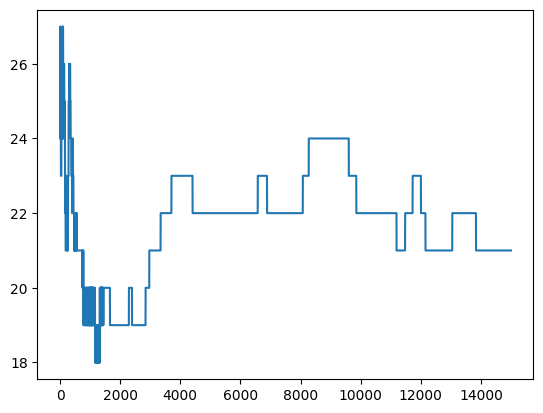

In [37]:
print(net_small[1])
n_params = sum([np.prod(param.shape) for param in net_small[-1].parameters()])
grad_matrix_ranks = compute_grad_matrix_ranks(net_small, x[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks)
# for i in range(m):
#   plt.xlim(0, 400)
#   plt.ylim(0, 0.15)
#   plt.plot(norm_small[::10, 0, i])
#   plt.title('lr={0}'.format(lr_small))
  #plt.plot(log2[::10, 1, i])

TwoLayerNN(
  (fc1): Linear(in_features=2, out_features=30, bias=False)
  (fc2): Linear(in_features=30, out_features=1, bias=False)
)


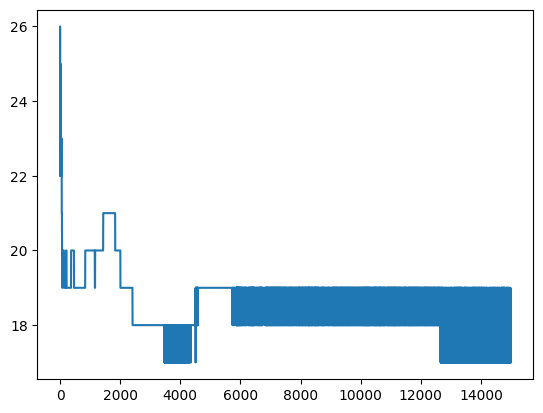

In [38]:
print(net_large[1])
n_params = sum([np.prod(param.shape) for param in net_large[-1].parameters()])
grad_matrix_ranks = compute_grad_matrix_ranks(net_large, x[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks)

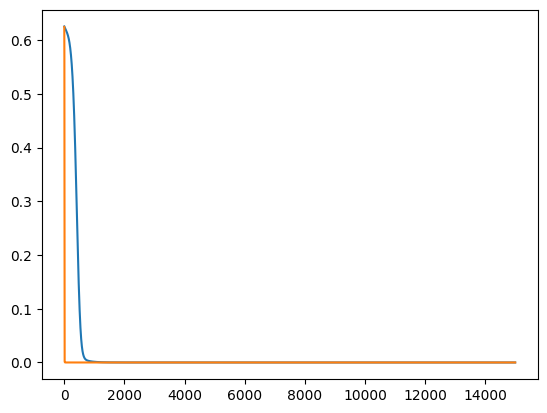

In [34]:
plt.plot(loss_small)
plt.plot(loss_large)